In [237]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import expon
from scipy.optimize import minimize_scalar
import cvxpy as cp
import heapq


# Data, E, S, M

In [238]:
def dataEntryCreator(d, A=0, B=0, mean=0, variance=0):
    '''
    This funtion will return a dataset with specific columns and rows(m, d) 
    in one specific distribution depend on parameters.
    
    Argument:
    d - Amount of values in each data entry
    A, B - parameters of uniform distribution
    mean, variance - parameters of normal distribution
    lbd - lambda is the parameter of exponential distribution
    
    Return:
    de - Data entry created with one specific distribution
    '''
    de = np.zeros(d)
    
    #uniform distribution
    if A!=0 and B!=0: 
        if mean!=0 or variance!=0:#checker of proper input
            return de
        de = np.random.uniform(A, B, d)
    
    #normal distribution
    elif mean!=0 or variance!=0:
        if A!=0 or B!=0: #checker of proper input
            return de
        de = np.random.normal(mean, variance, d)
    
#     #exponential distribution
#     elif lbd!=0:
#         if A!=0 or B!=0 or mean!=0 or variance!=0: #checker of proper input
#             return de
#         de = np.random.exponential(lbd, d)
        
    return de

In [239]:
# MONTE CARLO SIMULATION

# Function for testing if X1 is among the top k
def isFirstEntryAmongTopK_mce(de, k):
#     top_k_elements = heapq.nlargest(k, de)
#     if de[0] in top_k_elements:
#         return de[0], 1
#     else:
#         return 0, 0
    kth_largest = np.partition(de, -k)[-k]  # Partially sort and get the kth largest
    if de[0] >= kth_largest:
        return de[0], 1
    else:
        return 0, 0    

# Function for estimating the conditional expectation
def expectation_of_xAndx2(dt, k):
    t = 0
    t2 = 0
    num = 0
    for de in dt:
        res = isFirstEntryAmongTopK_mce(de, k)
        t += res[0]
        t2 += res[0]**2
        num += res[1]
    if num == 0:
        num = 1
    return t/num, t2/num

# Function for estimating the conditional expectation of the squared variable
# def expected_xi_2(dt, k):
#     t2 = 0
#     dt2 = [de**2 for de in dt]
#     num = 0
#     for i in range(len(dt)):
#         res = isFirstEntryAmongTopK_mce(dt[i], k)
#         if res[0] != 0:
#             t2 += dt2[i][0]
#             num += res[1]
#     if num == 0:
#         num = 1
#     return t2/num

In [240]:
# Analytic Method for Uniform Distribution

def expected_xi_unif(de, k, A, B):
    eXinK = 0
    n = len(de)
    for i in range(1, k + 1):
        eXinK += ((n-i+1)/(n+1)) * (B-A) + A
    return eXinK/k

def expected_xi2_unif(de, k, A, B):
    eXinK2 = 0
    n = len(de)
    for i in range(k):
        eXinK2 += ((((n-i+1)**2) * (B-A)**2) / (n+1)**2 + 
        (2*A*(n-i+1)*(B-A)) / (n+1) + 
        A**2 + 
        (i * (n+1-i) * (B-A)**2) / (((n+1)**2) * (n+2)) )
    return eXinK2/k

In [241]:
# Function for E(Q^TQ)
def eQTQ_ks(k, E, S, d):
    m = len(E)
    eQTQ = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            if i != j:
                eQTQ[i][j] = k[i] * k[j] * E[i] * E[j] / d
            else:
                eQTQ[i][j] = S[i] * k[i]

    return eQTQ

# Function for E(z^TQ)
def eZTQ_ks(k, E, M, S, d):
    m = len(E)
    eZTQ = np.zeros(m)
    for i in range(m):
        eZTQ[i] = (k[i] * (S[i] + E[i] * M.sum() - E[i]*M[i]))/d
    return eZTQ

# Function for the equality constraint matrix A and vector b
def equal_constr_ks(k, E, M, d):
    m = len(E)
    A = np.ones((2, m))
    b = np.ones((2, 1))
    b[0] = M.sum()
    for i in range(m):
        A[0][i] = k[i] * E[i] / d

    return A, b

# Monte Carlo Simulation for Uniform Data
# For Sanity Check

Using Expectation of Kth Order Statistic, E(X | X among k highest values) is 1.9380619380619382
With Monte Carlo Simulation, E(X | X among k highest values) converges to 1.9401667695672962
Using Expectation of Kth Order Statistic, E(X^2 | X among k highest values) is 3.77301208438933
With Monte Carlo Simulation, E(X^2 | X among k highest values) converges to 3.7657983900119647


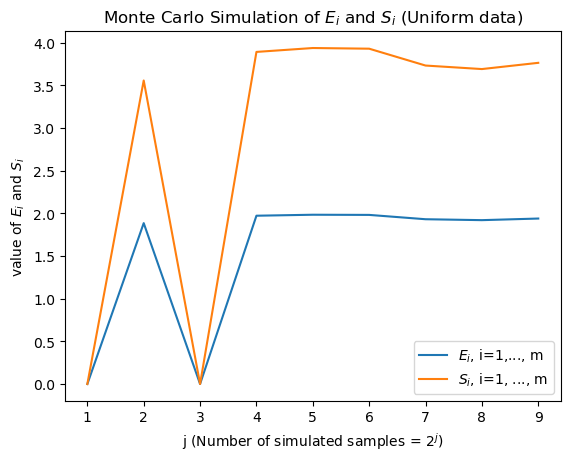

In [487]:
d = 1000
A = -2
B = 2
mean = 0
variance = 0
lbd = 0
k=30
deUni = dataEntryCreator(d, A, B, mean, variance, lbd)
print('Using Expectation of Kth Order Statistic, E(X | X among k highest values) is', expected_xi_unif(deUni, k, A, B))

exList = []
ex2List = []
for i in range(1,10):
    arr = [dataEntryCreator(d, A, B, mean, variance, lbd) for j in range(2**i)]
    ex = expected_xi(arr, k)
    exList.append(ex)
    ex2 = expected_xi_2(arr, k)
    ex2List.append(ex2)
x = np.arange(1, 10, 1)
plt.plot(x, exList, label='$E_i$, i=1,..., m')
print('With Monte Carlo Simulation, E(X | X among k highest values) converges to', exList[-1])

print('Using Expectation of Kth Order Statistic, E(X^2 | X among k highest values) is', expected_xi2_unif(deUni, k, A, B))
plt.plot(x, ex2List, label='$S_i$, i=1, ..., m')
print('With Monte Carlo Simulation, E(X^2 | X among k highest values) converges to', ex2List[-1])
plt.title('Monte Carlo Simulation of $E_i$ and $S_i$ (Uniform data)')
plt.xlabel('j (Number of simulated samples = $2^j$)')
plt.ylabel('value of $E_i$ and $S_i$')
plt.legend()
plt.show()

# Monte Carlo Simulation for Normal Data
# Simulate $E_i$ and $S_i$

With Monte Carlo Simulation, E(X | X among k highest values) converges to 5.536004955918096
With Monte Carlo Simulation, E(X^2 | X among k highest values) converges to 31.208769575855513


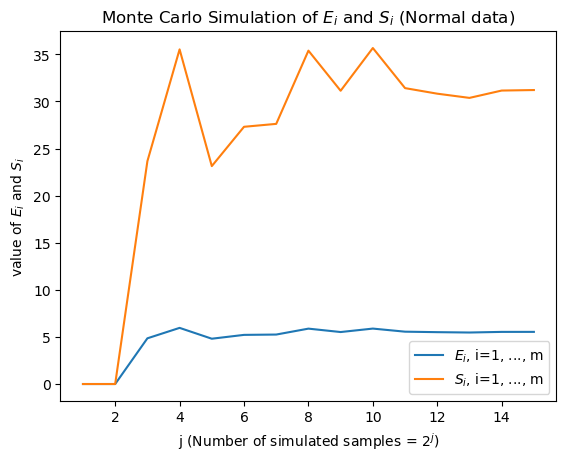

In [489]:
d = 1000
A = 0
B = 0
mean = 1
variance = 2
lbd = 0
k=30
# deNorm = dataEntryCreator(d, A, B, mean, variance, lbd)
# print('Using Expectation of Kth Order Statistic, E(X | X among k highest values) is', expected_xi_unif(deNorm, k, A, B))
exList = []
ex2List = []
for i in range(1,16):
    arr = [dataEntryCreator(d, A, B, mean, variance, lbd) for j in range(2**i)]
    ex = expected_xi(arr, k)
    exList.append(ex)
    ex2 = expected_xi_2(arr, k)
    ex2List.append(ex2)
    
x = np.arange(1, 16, 1)
plt.plot(x, exList, label='$E_i$, i=1, ..., m')
print('With Monte Carlo Simulation, E(X | X among k highest values) converges to', exList[-1])
# print('Using Expectation of Kth Order Statistic, E(X^2 | X among k highest values) is', expected_xi2_unif(deUni, k, A, B))
plt.plot(x, ex2List, label='$S_i$, i=1, ..., m')
print('With Monte Carlo Simulation, E(X^2 | X among k highest values) converges to', ex2List[-1])
plt.title('Monte Carlo Simulation of $E_i$ and $S_i$ (Normal data)')
plt.xlabel('j (Number of simulated samples = $2^j$)')
plt.ylabel('value of $E_i$ and $S_i$')
plt.legend()
plt.show()

# Quadratic Programming Function
# Uniform data
# $E_i$ and $S_i$ are computed explicitly

In [242]:
def quad_prog_func_a(d, A, B, K):
    
    m = len(K)
    de1 = np.zeros(d)
    
    E_a = np.array([expected_xi_unif(de1, K[i], A[i], B[i]) for i in range(m)])
    S_a = np.array([expected_xi2_unif(de1, K[i], A[i], B[i]) for i in range(m)])
    M_a = np.array([(A[i] + B[i])/2 for i in range(m)])
    
    # Define the problem data
    P = eQTQ_ks(K, E_a, S_a, d)  # A positive definite matrix
    q = eZTQ_ks(K, E_a, M_a, S_a, d)              # A column vector
    
    A_matrix = np.array([[K[i]*E_a[i]/d for i in range(m)], np.ones(m)])     
    b_vec = np.array([M_a.sum(), len(E_a)])                 # A column vector for equality constraints

    # Define the optimization variables
    x = cp.Variable(m)

    # Define the quadratic objective function
    objective = cp.Minimize(cp.quad_form(x, P) - 2*q.T @ x)

    # Define the constraints
    constraints = [A_matrix @ x == b_vec]

    # Create the problem instance
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve()

    # Retrieve the optimal solution
    optimal_x = x.value
    
    return optimal_x, result, E_a, S_a, M_a

In [243]:
def lagra_approxm_qp_a(d, A, B, K):
    m = len(K)
    de1 = np.zeros(d)
    
    E_a = np.array([expected_xi_unif(de1, K[i], A[i], B[i]) for i in range(m)])
    S_a = np.array([expected_xi2_unif(de1, K[i], A[i], B[i]) for i in range(m)])
    M_a = np.array([(A[i] + B[i])/2 for i in range(m)])
    
    # Define the problem data
    P = eQTQ_ks(K, E_a, S_a, d)  # A positive definite matrix
    q = eZTQ_ks(K, E_a, M_a, S_a, d)              # A column vector
    
    A_matrix = np.array([[K[i]*E_a[i]/d for i in range(m)], np.ones(m)])     
    b_vec = np.array([M_a.sum(), len(E_a)])
    
    Pinv = np.linalg.inv(P)
    W = Pinv @ q - Pinv @ A_matrix.T @ np.linalg.inv(A_matrix @ Pinv @ A_matrix.T) @ A_matrix @ Pinv @ q + Pinv @ A_matrix.T @ np.linalg.inv(A_matrix @ Pinv @ A_matrix.T) @ b_vec
    
    return W

In [348]:
def quad_prog_func_uncstr_a(d, A, B, K):
    
    m = len(K)
    de1 = np.zeros(d)
    
    E_a = np.array([expected_xi_unif(de1, K[i], A[i], B[i]) for i in range(m)])
    S_a = np.array([expected_xi2_unif(de1, K[i], A[i], B[i]) for i in range(m)])
    M_a = np.array([(A[i] + B[i])/2 for i in range(m)])
    
    # Define the problem data
    P = eQTQ_ks(K, E_a, S_a, d)  # A positive definite matrix
    q = eZTQ_ks(K, E_a, M_a, S_a, d)              # A column vector

    # Define the optimization variables
    x = cp.Variable(m)

    # Define the quadratic objective function
    objective = cp.Minimize(cp.quad_form(x, P) - 2*q.T @ x)

    # Define the constraints
    constraints = [np.ones(m) @ x == m]

    # Create the problem instance
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve()

    # Retrieve the optimal solution
    optimal_x = x.value
    
    return optimal_x, result, E_a, S_a, M_a

In [349]:
def quad_prog_func_Compuncstr_a(d, A, B, K):
    
    m = len(K)
    de1 = np.zeros(d)
    
    E_a = np.array([expected_xi_unif(de1, K[i], A[i], B[i]) for i in range(m)])
    S_a = np.array([expected_xi2_unif(de1, K[i], A[i], B[i]) for i in range(m)])
    M_a = np.array([(A[i] + B[i])/2 for i in range(m)])
    
    # Define the problem data
    P = eQTQ_ks(K, E_a, S_a, d)  # A positive definite matrix
    q = eZTQ_ks(K, E_a, M_a, S_a, d)              # A column vector

    # Define the optimization variables
    x = cp.Variable(m)

    # Define the quadratic objective function
    objective = cp.Minimize(cp.quad_form(x, P) - 2*q.T @ x)

    # Define the constraints
    constraints = [np.ones(m) @ x == m]

    # Create the problem instance
    problem = cp.Problem(objective)

    # Solve the problem
    result = problem.solve()

    # Retrieve the optimal solution
    optimal_x = x.value
    
    return optimal_x, result, E_a, S_a, M_a

In [245]:
def quad_prog_func_approxAsym_a(d, A, B, K):
    
    m = len(K)
    de1 = np.zeros(d)
    
    E_a = np.array([expected_xi_unif(de1, K[i], A[i], B[i]) for i in range(m)])
    S_a = np.array([expected_xi2_unif(de1, K[i], A[i], B[i]) for i in range(m)])
    M_a = np.array([(A[i] + B[i])/2 for i in range(m)])
    
    # Define the problem data
    P = eQTQ_ks(K, E_a, S_a, d)  # A positive definite matrix
    q = eZTQ_ks(K, E_a, M_a, S_a, d)              # A column vector
    
    A_matrix = np.array([[K[i]*E_a[i]/d for i in range(m)], np.ones(m)])
    A_matrix[0][0] = 0
    b_vec = np.array([M_a.sum(), len(E_a)])                 # A column vector for equality constraints

    # Define the optimization variables
    x = cp.Variable(m)

    # Define the quadratic objective function
    objective = cp.Minimize(cp.quad_form(x, P) - 2*q.T @ x)

    # Define the constraints
    constraints = [A_matrix @ x == b_vec]

    # Create the problem instance
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve()

    # Retrieve the optimal solution
    optimal_x = x.value
    
    return optimal_x, result, E_a, S_a, M_a

In [483]:
def MSE_test_unifW_a(d, A, B, K):
    m = len(K)
    W = np.ones(m)
    de1 = np.zeros(d)
    
    E_a = np.array([expected_xi_unif(de1, K[i], A[i], B[i]) for i in range(m)])
    S_a = np.array([expected_xi2_unif(de1, K[i], A[i], B[i]) for i in range(m)])
    M_a = np.array([(A[i] + B[i])/2 for i in range(m)])
    
    QTQ = eQTQ_ks(K, E_a, S_a, d)  # A positive definite matrix
    ZTQ = eZTQ_ks(K, E_a, M_a, S_a, d)  
    return W.T @ QTQ @ W - 2 * ZTQ @ W

In [262]:
def quad_prog_asymp(d, A, B, K):
    
    m = len(K)
    de1 = np.zeros(d)
    
    E_a = np.array([expected_xi_unif(de1, K[i], A[i], B[i]) for i in range(m)])
    S_a = np.array([expected_xi2_unif(de1, K[i], A[i], B[i]) for i in range(m)])
    M_a = np.array([(A[i] + B[i])/2 for i in range(m)])
    
    # Define the problem data
    P = np.diag(np.array(S_a)*np.array(K))  # A positive definite matrix

    # Define the optimization variables
    x = cp.Variable(m)

    # Define the quadratic objective function
    objective = cp.Minimize(cp.quad_form(x, P))

    # Define the constraints
    constraints = [np.ones(m) @ x == m]

    # Create the problem instance
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve()

    # Retrieve the optimal solution
    optimal_x = x.value
    
    return optimal_x, result, E_a, S_a, M_a

In [504]:
def K_3plots_a(d, m, kVar, kmean):
    A = np.array([random.uniform(-1, -0.1) for _ in range(m)])
    # B = np.array([random.randint(0.1, 1) for _ in range(m)])
    B = -A
    # K_old = [random.randint(5, d - 2) for _ in range(m-1)]
    K_old = []
#     kmean = 1000
    for i in range(m):
        temp = int(random.gauss(kmean, kVar))
        while temp > d and temp < 0:
            temp = int(random.gauss(kmean, kVar))
        K_old.append(temp)
#     K_old = [int(random.gauss(80, kVar)) for _ in range(m-1)]
#     K_old = [1 for _ in range(m-1)]
    w_list_1 = []
    w_list_all = []
    w_list_unconstr = []
    w_list_Comunconstr = []
    w1_list_approxByLag = []
    w1_list_actualAsym = []

    MSE_list_actualAsym = []
    MSE_list_1 = []
    MSE_list_uniW = []
    MSE_list_uncstr = []
    MSE_list_Comunconstr = []
    MSE_list_approxAsym = []
    
    k1_list_1 = np.array(list(range(1, d + 1)))
    Elist = []
    Slist = []
    Mlist = []
    Klist = []

    for k1 in k1_list_1:
        K_old[0] = k1
        Klist.append(K_old)
        K = np.array(K_old)
#         K_new = [k1] + K_old
#         Klist.append(K_new)
#         K = np.array(K_new)

        sol = quad_prog_func_a(d, A, B, K)
        sol2 = quad_prog_func_uncstr_a(d, A, B, K)
        sol_Comunconstr = quad_prog_func_Compuncstr_a(d, A, B, K)
        sol3 = quad_prog_func_approxAsym_a(d, A, B, K)
        sol_asymp = quad_prog_asymp(d, A, B, K)
        MSE_uniW = MSE_test_unifW_a(d, A, B, K)
        
        w1_list_actualAsym.append(sol_asymp[0][0])
        MSE_list_actualAsym.append(sol_asymp[1])
        
        W = lagra_approxm_qp_a(d, A, B, K)


        w_list_all.append(sol[0])
        w_list_1.append(sol[0][0])
        w_list_unconstr.append(sol2[0][0])
        w_list_Comunconstr.append(sol_Comunconstr[0][0])
        w1_list_approxByLag.append(W[0])
        
        MSE_list_1.append(sol[1])
        MSE_list_uniW.append(MSE_uniW)
        MSE_list_uncstr.append(sol2[1])
        MSE_list_Comunconstr.append(sol_Comunconstr[1])
        MSE_list_approxAsym.append(sol3[1])
        #E, S, M = sol[2], sol[3], sol[4]
        
        Elist.append(sol[2])
        Mlist.append(sol[3])
        Slist.append(sol[4])
    Diff_arr_from_uncstr = np.abs(np.array(MSE_list_1) - np.array(MSE_list_uncstr))

    fig, axs = plt.subplots(7, 2, figsize=(10, 25))
#     axs = axs.flatten()
    axs[0, 0].plot(w_list_1)
    axs[0,0].set_xlabel('k1')
    axs[0,0].set_ylabel('w1 in Actual Case')
    
    axs[0,1].plot(MSE_list_1)
#     index_to_mark = MSE_list_1.index(kmean)
#     axs[0,1].scatter([index_to_mark], [index_to_mark], color='red', marker='o', label=f'MSE when k1={kmean}')
    axs[0,1].set_xlabel('k1')
    axs[0,1].set_ylabel('MSE in Actual Case')

    
    axs[1,0].plot(w1_list_actualAsym)
    axs[1,0].set_xlabel('k1')
    axs[1,0].set_ylabel('w1 by actual asymptotic case')

    axs[1,1].plot(MSE_list_actualAsym)
#     index_to_mark_asymp = MSE_list_actualAsym.index(kmean)
#     axs[2,1].scatter([index_to_mark_asymp], [index_to_mark_asymp], color='red', marker='o', label=f'MSE when k1={kmean}')
    axs[1,1].set_xlabel('k1')
    axs[1,1].set_ylabel('MSE by actual asymptotic case')
    axs[1,1].plot(kmean, MSE_list_actualAsym[kmean], 'ro', label=f'MSE when k1={kmean}')
    axs[1,1].legend()

#     index_to_mark = w_list_1.index(max(w_list_1))
#     axs[1].scatter([index_to_mark], [index_to_mark], color='red', marker='o', label='Marked Point')
#     axs[1].legend()
    axs[2,0].plot(w_list_unconstr)
    axs[2,0].set_xlabel('k1')
    axs[2,0].set_ylabel('w1 in case without constraints')


    axs[2,1].plot(MSE_list_uncstr)
#     index_to_mark_unconst = MSE_list_uncstr.index(kmean)
#     axs[2,1].scatter([index_to_mark_unconst], [index_to_mark_unconst], color='red', marker='o', label=f'MSE when k1={kmean}')
    axs[2,1].set_xlabel('k1')
    axs[2,1].set_ylabel('MSE in case without constraints')
    axs[2,1].plot(kmean, MSE_list_uncstr[kmean], 'ro', label=f'MSE when k1={kmean}')
    axs[2,1].legend()
    
    axs[3,0].plot(w1_list_approxByLag)
    axs[3,0].set_xlabel('k1')
    axs[3,0].set_ylabel('w1 by approximate asymptotic case')
    
    axs[3,1].plot(MSE_list_approxAsym)
    axs[3,1].set_xlabel('k1')
    axs[3,1].set_ylabel('MSE by approximate asymptotic case')

    axs[4,0].plot(w_list_Comunconstr)
    axs[4,0].set_xlabel('k1')
    axs[4,0].set_ylabel('w1 no constr at all')
    
    axs[4,1].plot(MSE_list_Comunconstr)
    axs[4,1].set_xlabel('k1')
    axs[4,1].set_ylabel('MSE no constr at all')

    axs[5, 0].plot(MSE_list_approxAsym[200:])
    axs[5,0].set_ylabel('MSE approxAsym from 200')
    
    axs[5, 1].plot(MSE_list_uncstr[200:])
    axs[5,1].set_ylabel('MSE unconstr from 200')
    
    axs[6,0].plot(MSE_list_1)

    axs[6,0].set_xlabel('k1')
    axs[6,0].set_ylabel('MSE in Actual Case')
    
    axs[6,1].plot(MSE_list_uniW)
    axs[6,1].set_xlabel('k1')
    axs[6,1].set_ylabel('MSE with Uniform Weight')
    print('min w1:', min(w_list_1))
    print('w list:', w_list_all[w_list_1.index(min(w_list_1))])
    print('sum of weights:', sum(w_list_all[0]))
    print('corresponding k1:',  k1_list_1[w_list_1.index(min(w_list_1))])
    print('corresponding mse:', MSE_list_1[w_list_1.index(min(w_list_1))])
    print('K:', K)
    print('Lowest MSE in Actual Case:',  min(MSE_list_1))

    plt.subplots_adjust(wspace=0.5)

    plt.show()

min w1: -0.6266850184411545
w list: [-0.62668502 -0.09732134  0.71414509 -0.37599972 -0.3021875   0.97233556
  0.28850811 -0.38215161 -0.35727112  0.11122525 -0.39787929 15.11678903
  0.74191467 -0.18808047  3.69237251 -0.38238256 -0.40296569 -0.35766349
  2.59494589 -0.36164831]
sum of weights: 20.000000000000004
corresponding k1: 47
corresponding mse: 94.85276599673102
K: [1000   20   19   19   19   20   20   19   19   19   20   20   22   20
   20   19   20   19   20   19]
Lowest MSE in Actual Case: 49.8189001037962


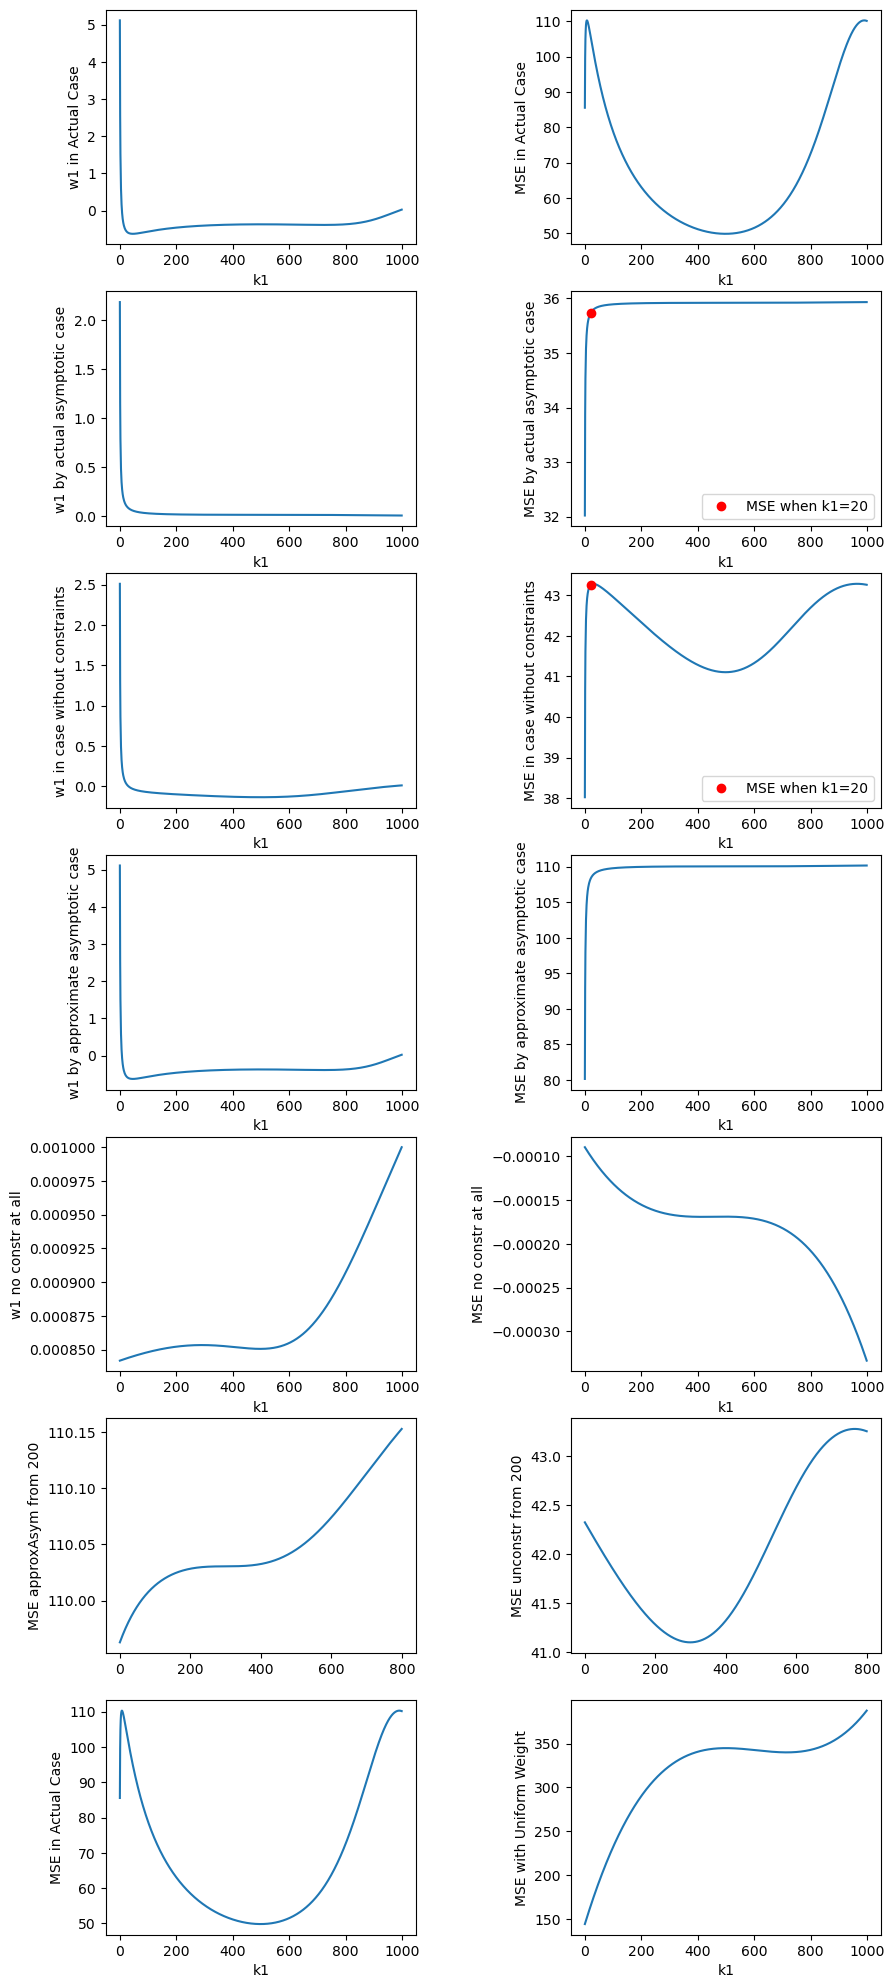

In [505]:
# for i in range(1, 5):
#     print('kVar =', i/10)
K_3plots_a(1000, 20, 0.8, 20)

min w1: -0.7577949483725405
w list: [-7.57794948e-01  8.80557935e+00  4.13517589e-01 -3.94900360e-01
  1.30120441e+00  6.76100589e-01 -4.21586958e-01 -4.41263650e-01
 -9.73252483e-02  1.50471877e-03  6.64321689e+00 -2.61378844e-01
 -2.14104502e-01  2.02572176e-01 -3.88076105e-01  6.52175113e+00
 -4.25307367e-01 -3.55205226e-01 -4.17728475e-01 -3.90775170e-01]
sum of weights: 19.999999999999993
corresponding k1: 48
corresponding mse: 110.05003060338126
K: [3000   17   19   21   18   18   20   21   19   20   20   19   19   20
   21   18   20   19   20   19]
Lowest MSE in Actual Case: 45.86294439517188


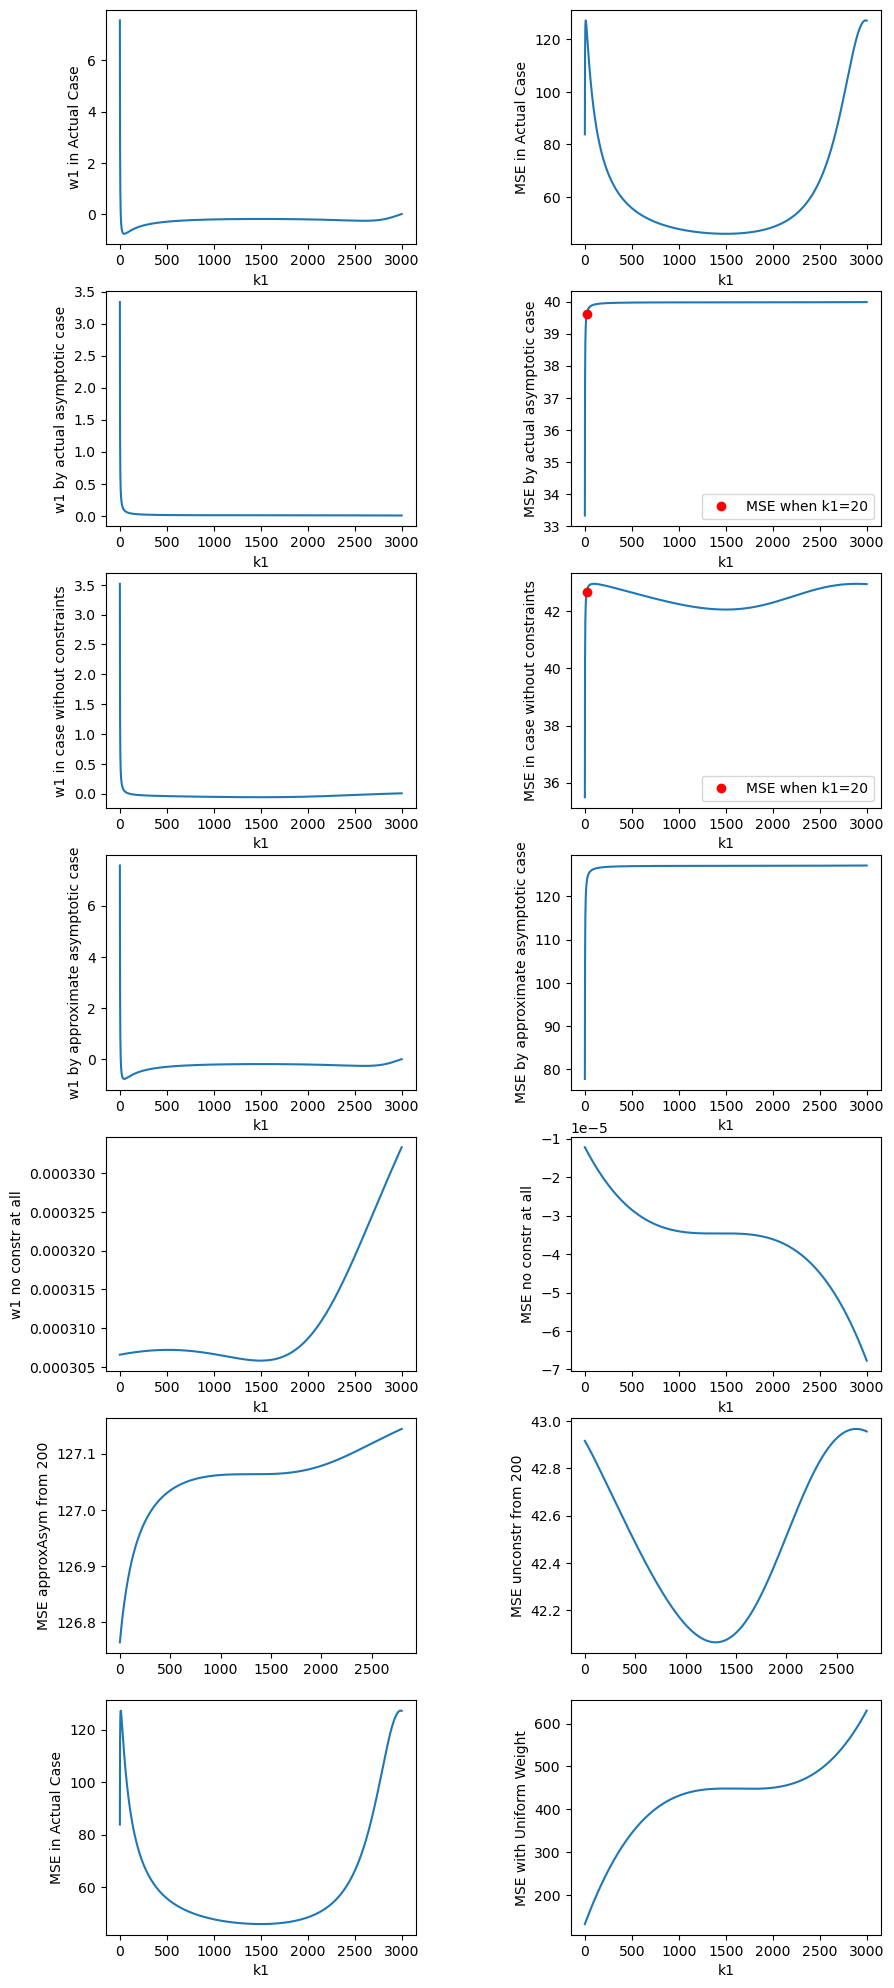

In [506]:
K_3plots_a(3000, 20, 0.8, 20)

# Monte Carlo Simulation

In [309]:
# Function for solving a quad prog problem for the inequality UNCONSTRAIED scenario


def quad_prog_func(d, AList, BList, meanList, varianceList, K):
    
    m = len(K)

    E_a = []
    S_a = []
    M_a = []
    
    for i in range(m):
        if len(AList) > 1 and len(BList) > 1:
            dt = [dataEntryCreator(d, AList[i], BList[i], 0, 0) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])
            
            E_a.append(ex)
            S_a.append(ex2)
            M_a.append((AList[i]+BList[i])/2)
            
        elif len(meanList) > 1 and len(varianceList) > 1:
            dt = [dataEntryCreator(d, 0, 0, meanList[i], varianceList[i]) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])

            E_a.append(ex)
            S_a.append(ex2)
            M_a.append(meanList[i])
            
    E_a = np.array(E_a)
    S_a = np.array(S_a)
    M_a = np.array(M_a)
    
    # Define the problem data
    P = eQTQ_ks(K, E_a, S_a, d)  # A positive definite matrix
    q = eZTQ_ks(K, E_a, M_a, S_a, d)              # A column vector
    
    A_matrix = np.array([[K[i]*E_a[i]/d for i in range(m)], np.ones(m)])     
    b_vec = np.array([M_a.sum(), len(E_a)])                 # A column vector for equality constraints

    # Define the optimization variables
    x = cp.Variable(m)

    # Define the quadratic objective function
    objective = cp.Minimize(cp.quad_form(x, P) - 2*q.T @ x)

    # Define the constraints
    constraints = [A_matrix @ x == b_vec]

    # Create the problem instance
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve()

    # Retrieve the optimal solution
    optimal_x = x.value
    
    return optimal_x, result, E_a, S_a, M_a

def lagra_approxm_qp(d, AList, BList, meanList, varianceList, K):
    
    m = len(K)
    
    E_a = []
    S_a = []
    M_a = []
    
    for i in range(m):
        if len(AList) > 1 and len(BList) > 1:
            dt = [dataEntryCreator(d, AList[i], BList[i], 0, 0) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])
            
            E_a.append(ex)
            S_a.append(ex2)
            M_a.append((AList[i]+BList[i])/2)
            
        elif len(meanList) > 1 and len(varianceList) > 1:
            dt = [dataEntryCreator(d, 0, 0, meanList[i], varianceList[i]) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])

            E_a.append(ex)
            S_a.append(ex2)
            M_a.append(meanList[i])
            
    E_a = np.array(E_a)
    S_a = np.array(S_a)
    M_a = np.array(M_a)
    
    # Define the problem data
    P = eQTQ_ks(K, E_a, S_a, d)  # A positive definite matrix
    q = eZTQ_ks(K, E_a, M_a, S_a, d)              # A column vector
    
    A_matrix = np.array([[K[i]*E_a[i]/d for i in range(m)], np.ones(m)])     
    b_vec = np.array([M_a.sum(), len(E_a)])
    
    Pinv = np.linalg.inv(P)
    W = Pinv @ q - Pinv @ A_matrix.T @ np.linalg.inv(A_matrix @ Pinv @ A_matrix.T) @ A_matrix @ Pinv @ q + Pinv @ A_matrix.T @ np.linalg.inv(A_matrix @ Pinv @ A_matrix.T) @ b_vec
    
    return W

def quad_prog_func_uncstr(d, AList, BList, meanList, varianceList, K):
    
    m = len(K)
    
    E_a = []
    S_a = []
    M_a = []
    
    for i in range(m):
        if len(AList) > 1 and len(BList) > 1:
            dt = [dataEntryCreator(d, AList[i], BList[i], 0, 0) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])
            
            E_a.append(ex)
            S_a.append(ex2)
            M_a.append((AList[i]+BList[i])/2)
            
        elif len(meanList) > 1 and len(varianceList) > 1:
            dt = [dataEntryCreator(d, 0, 0, meanList[i], varianceList[i]) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])

            E_a.append(ex)
            S_a.append(ex2)
            M_a.append(meanList[i])
            
    E_a = np.array(E_a)
    S_a = np.array(S_a)
    M_a = np.array(M_a)
    
    # Define the problem data
    P = eQTQ_ks(K, E_a, S_a, d)  # A positive definite matrix
    q = eZTQ_ks(K, E_a, M_a, S_a, d)              # A column vector

    # Define the optimization variables
    x = cp.Variable(m)

    # Define the quadratic objective function
    objective = cp.Minimize(cp.quad_form(x, P) - 2*q.T @ x)

    # Define the constraints
    constraints = [np.ones(m) @ x == m]

    # Create the problem instance
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve()

    # Retrieve the optimal solution
    optimal_x = x.value
    
    return optimal_x, result, E_a, S_a, M_a

def quad_prog_func_approxAsym(d, AList, BList, meanList, varianceList, K):
    
    m = len(K)
    de1 = np.zeros(d)
    
    E_a = []
    S_a = []
    M_a = []
    
    for i in range(m):
        if len(AList) > 1 and len(BList) > 1:
            dt = [dataEntryCreator(d, AList[i], BList[i], 0, 0) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])
            
            E_a.append(ex)
            S_a.append(ex2)
            M_a.append((AList[i]+BList[i])/2)
            
        elif len(meanList) > 1 and len(varianceList) > 1:
            dt = [dataEntryCreator(d, 0, 0, meanList[i], varianceList[i]) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])

            E_a.append(ex)
            S_a.append(ex2)
            M_a.append(meanList[i])
            
    E_a = np.array(E_a)
    S_a = np.array(S_a)
    M_a = np.array(M_a)
    
    # Define the problem data
    P = eQTQ_ks(K, E_a, S_a, d)  # A positive definite matrix
    q = eZTQ_ks(K, E_a, M_a, S_a, d)              # A column vector
    
    A_matrix = np.array([[K[i]*E_a[i]/d for i in range(m)], np.ones(m)])
    A_matrix[0][0] = 0
    b_vec = np.array([M_a.sum(), len(E_a)])                 # A column vector for equality constraints

    # Define the optimization variables
    x = cp.Variable(m)

    # Define the quadratic objective function
    objective = cp.Minimize(cp.quad_form(x, P) - 2*q.T @ x)

    # Define the constraints
    constraints = [A_matrix @ x == b_vec]

    # Create the problem instance
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve()

    # Retrieve the optimal solution
    optimal_x = x.value
    
    return optimal_x, result, E_a, S_a, M_a

def quad_prog_asymp_mt(d, AList, BList, meanList, varianceList, K):
    
    m = len(K)
    de1 = np.zeros(d)
    
#     E_a = np.array([expected_xi_unif(de1, K[i], A[i], B[i]) for i in range(m)])
#     S_a = np.array([expected_xi2_unif(de1, K[i], A[i], B[i]) for i in range(m)])
#     M_a = np.array([(A[i] + B[i])/2 for i in range(m)])
    E_a = []
    S_a = []
    M_a = []
    
    for i in range(m):
        if len(AList) > 1 and len(BList) > 1:
            dt = [dataEntryCreator(d, AList[i], BList[i], 0, 0) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])
            
            E_a.append(ex)
            S_a.append(ex2)
            M_a.append((AList[i]+BList[i])/2)
            
        elif len(meanList) > 1 and len(varianceList) > 1:
            dt = [dataEntryCreator(d, 0, 0, meanList[i], varianceList[i]) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])

            E_a.append(ex)
            S_a.append(ex2)
            M_a.append(meanList[i])
            
    E_a = np.array(E_a)
    S_a = np.array(S_a)
    M_a = np.array(M_a)
    
    # Define the problem data
    P = np.diag(np.array(S_a)*np.array(K))  # A positive definite matrix

    # Define the optimization variables
    x = cp.Variable(m)

    # Define the quadratic objective function
    objective = cp.Minimize(cp.quad_form(x, P))

    # Define the constraints
    constraints = [np.ones(m) @ x == m]

    # Create the problem instance
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve()

    # Retrieve the optimal solution
    optimal_x = x.value
    
    return optimal_x, result, E_a, S_a, M_a

def MSE_test_unifW(QTQ, ZTQ, m):
    W = np.ones(m)
    return W.T @ QTQ @ W - 2 * ZTQ @ W

In [310]:
def K_3plots(d, m, ABrange, VarRange, kVar):
    #we assume the distribution is Uniform(-n, n) except for Uniform(0,0)
    if ABrange > 0.1 and VarRange == 0:
        print('this is uniform!')
        A = np.array([random.uniform(-ABrange, -0.1) for _ in range(m)])
        B = -A
        mean = []
        variance = []
    elif VarRange > 0 and ABrange == 0:
        print('this is normal!')
        mean = np.zeros(m)
        variance = np.array([random.uniform(0.1, VarRange) for _ in range(m)])
        A = []
        B = []
        
    K_old = []
    for i in range(m):
        temp = int(random.gauss(20, kVar))
        while temp > d and temp < 0:
            temp = int(random.gauss(20, kVar))
        K_old.append(temp)

    w_list_1 = []
    w_list_all = []
    w_list_unconstr = []
    w1_list_approxByLag = []
    w1_list_actualAsym = []
    
    MSE_list_1 = []
    MSE_list_uncstr = []
    MSE_list_approxAsym = []
    MSE_list_actualAsym = []
    
    k1_list_1 = np.array(list(range(1, d + 1)))
    Elist = []
    Slist = []
    Mlist = []
    Klist = []

    for k1 in k1_list_1:
        K_old[0] = k1
        Klist.append(K_old)
        K = np.array(K_old)
#         K_new = [k1] + K_old
#         Klist.append(K_new)
#         K = np.array(K_new)

        sol = quad_prog_func(d, A, B,mean,variance, K)
        sol2 = quad_prog_func_uncstr(d, A, B,mean,variance, K)
        sol3 = quad_prog_func_approxAsym(d, A, B,mean,variance, K)
        sol_actualAsym = quad_prog_asymp_mt(d, A, B,mean,variance, K)
#         W = lagra_approxm_qp(d, A, B,[],[], K)

    
        w_list_all.append(sol[0])
        w_list_1.append(sol[0][0])
        w_list_unconstr.append(sol2[0][0])
        w1_list_approxByLag.append(sol3[0][0])
        w1_list_actualAsym.append(sol_actualAsym[0][0])
#         w1_list_approxByLag.append(W[0])
        
        MSE_list_1.append(sol[1])
        MSE_list_uncstr.append(sol2[1])
        MSE_list_approxAsym.append(sol3[1])
        MSE_list_actualAsym.append(sol_actualAsym[1])
        #E, S, M = sol[2], sol[3], sol[4]
        
        Elist.append(sol[2])
        Mlist.append(sol[3])
        Slist.append(sol[4])
    print(K_old)

    Diff_arr_from_uncstr = np.abs(np.array(MSE_list_1) - np.array(MSE_list_uncstr))

    fig, axs = plt.subplots(4, 2, figsize=(10, 15))
#     axs = axs.flatten()
#     axs[0, 0].plot(w_list_1)
#     axs[0,0].set_xlabel('k1')
#     axs[0,0].set_ylabel('w1')
    
#     axs[0,1].plot(MSE_list_1)
#     axs[0,1].set_xlabel('k1')
#     axs[0,1].set_ylabel('MSE')
    
#     axs[1,0].plot(w_list_1)
#     axs[1,0].set_xlabel('k1')
#     axs[1,0].set_ylabel('w1 by Lagr')
    
#     axs[1,1].plot(MSE_list_approxAsym)
#     axs[1,1].set_xlabel('k1')
#     axs[1,1].set_ylabel('MSE with constraint in asymptotic case')
# #     index_to_mark = w_list_1.index(max(w_list_1))
# #     axs[1].scatter([index_to_mark], [index_to_mark], color='red', marker='o', label='Marked Point')
# #     axs[1].legend()
#     axs[2,0].plot(MSE_list_uncstr)
#     axs[2,0].set_xlabel('k1')
#     axs[2,0].set_ylabel('MSE without constraints')

#     axs[2,1].plot(Diff_arr_from_uncstr)
#     axs[2,1].set_xlabel('k1')
#     axs[2,1].set_ylabel('diff from MSE without constraints')
    axs[0, 0].plot(w_list_1)
    axs[0,0].set_xlabel('k1')
    axs[0,0].set_ylabel('w1 in Actual Case')
    
    axs[0,1].plot(MSE_list_1)
    axs[0,1].set_xlabel('k1')
    axs[0,1].set_ylabel('MSE in Actual Case')
    
    axs[1,0].plot(w1_list_actualAsym)
    axs[1,0].set_xlabel('k1')
    axs[1,0].set_ylabel('w1 by actual asymptotic case')
#     axs[1,0].plot(w_list_1)
#     axs[1,0].set_xlabel('k1')
#     axs[1,0].set_ylabel('w1 by approximate asymptotic case')
    axs[1,1].plot(MSE_list_actualAsym)
    axs[1,1].set_xlabel('k1')
    axs[1,1].set_ylabel('MSE by actual asymptotic case')
#     axs[1,1].plot(MSE_list_approxAsym)
#     axs[1,1].set_xlabel('k1')
#     axs[1,1].set_ylabel('MSE by approximate asymptotic case')

#     index_to_mark = w_list_1.index(max(w_list_1))
#     axs[1].scatter([index_to_mark], [index_to_mark], color='red', marker='o', label='Marked Point')
#     axs[1].legend()
    axs[2,0].plot(w_list_unconstr)
    axs[2,0].set_xlabel('k1')
    axs[2,0].set_ylabel('w1 in case without constraints')

#     axs[2,1].plot(Diff_arr_from_uncstr)
#     axs[2,1].set_xlabel('k1')
#     axs[2,1].set_ylabel('diff from MSE without constraints')
    axs[2,1].plot(MSE_list_uncstr)
    axs[2,1].set_xlabel('k1')
    axs[2,1].set_ylabel('MSE in case without constraints')
    
    axs[3,0].plot(w1_list_approxByLag)
    axs[3,0].set_xlabel('k1')
    axs[3,0].set_ylabel('w1 by approximate asymptotic case')
    
    axs[3,1].plot(MSE_list_approxAsym)
    axs[3,1].set_xlabel('k1')
    axs[3,1].set_ylabel('MSE by approximate asymptotic case')
    
#     axs[1,1].plot(MSE_UniWtest_list)
#     axs[1,1].set_xlabel('k1')
#     axs[1,1].set_ylabel('MSE with Uniform Weight')

#     axs[5].plot(w_list_all)
#     axs[5].set_xlabel('k1')
#     axs[5].set_ylabel('w')
    print('min w1:', min(w_list_1))
    print('w list:', w_list_all[w_list_1.index(min(w_list_1))])
    print('sum of weights:', sum(w_list_all[0]))
    print('corresponding k1:',  k1_list_1[w_list_1.index(min(w_list_1))])
    print('corresponding mse:', MSE_list_1[w_list_1.index(min(w_list_1))])

#     print('min MSE = ', min(MSE_list_1))
#     print('corresponding w = ', w_list_1[MSE_list_1.index(min(MSE_list_1))])
#     print('corresponding k1 =', k1_list_1[MSE_list_1.index(min(MSE_list_1))])
    plt.subplots_adjust(wspace=0.5)
    plt.show()

# MCS - Uniform Distribution

kVar = 0.5
this is uniform!
[500, 20, 19, 21, 21, 19, 20, 21, 20, 19, 20, 19, 20, 20, 19, 20, 19, 20, 20, 20]
min w1: -1.0882409435901272
w list: [-1.08824094e+00 -8.80290360e-02  1.50999775e-01 -7.53152535e-02
  2.09258426e+00 -4.61180127e-02 -6.98680221e-02 -9.34490960e-02
 -1.80690181e-02  1.03138432e+00  1.02993713e-01  5.11162223e-02
  1.22190038e+00 -1.02045921e-01  1.41950061e+00 -5.66764121e-02
 -1.14286705e-02  1.41395056e+01  1.44121804e-01  1.29513371e+00]
sum of weights: 20.0
corresponding k1: 225
corresponding mse: 60.27423995542225


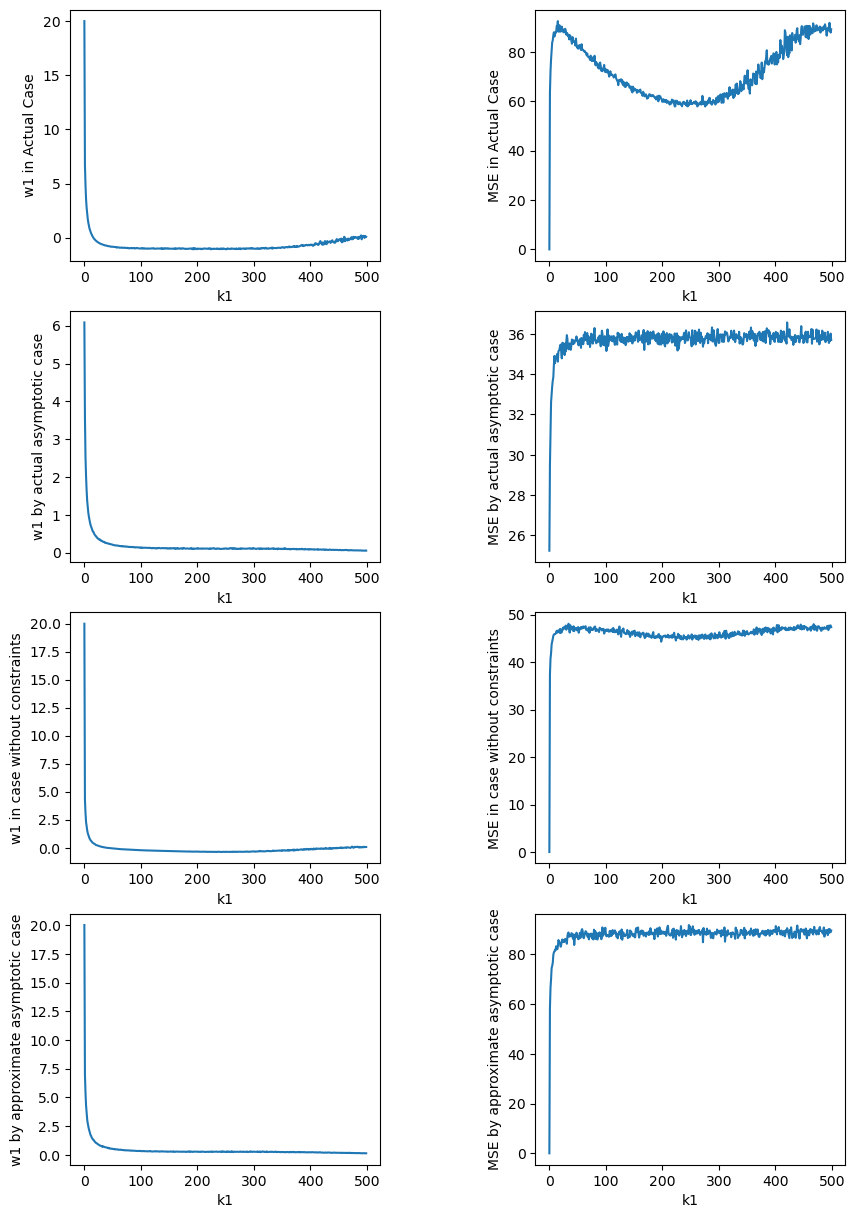

In [311]:
# Monte carlo for Uniform - Data varies less
print('kVar =', 0.5)
K_3plots(500, 20,1, 0, 0.5)

kVar = 0.5
this is uniform!
[500, 19, 20, 19, 20, 20, 19, 19, 20, 20, 19, 20, 19, 19, 19, 19, 19, 19, 18, 20]
min w1: -0.25072024121355213
w list: [-2.50720241e-01 -5.15070933e-02  1.08190095e-01 -4.77028684e-03
  1.03830835e+00  7.01267752e-01 -4.27835085e-02  1.17584214e+00
  4.00042959e-01  6.18726315e-02 -4.09440862e-02 -5.14488400e-02
  2.19333935e-02 -4.43942321e-02  1.70607139e+01 -1.03092235e-02
 -4.88056481e-02  8.12359892e-02 -4.90072011e-02 -5.47168235e-02]
sum of weights: 20.000000000000004
corresponding k1: 234
corresponding mse: 135.6149586371195


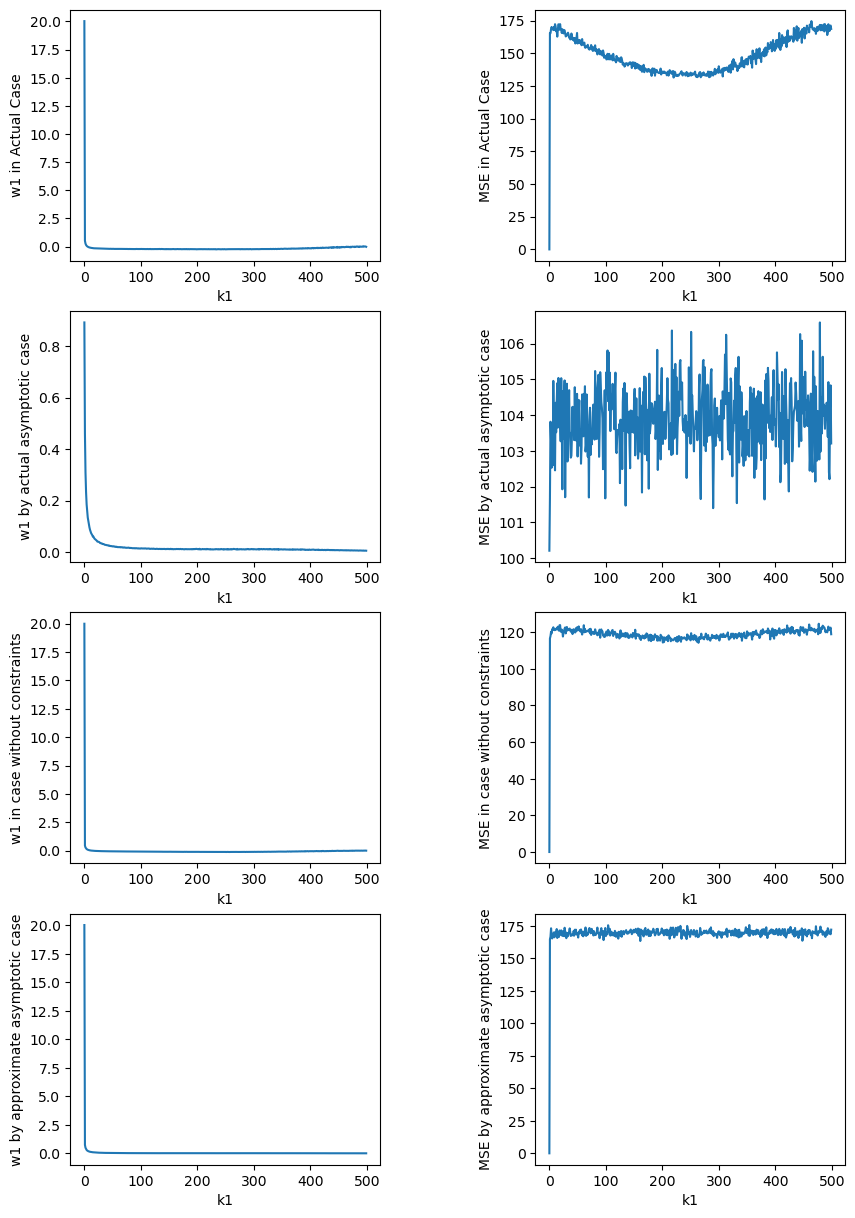

In [325]:
# Monte carlo for Uniform - Data varies more
print('kVar =', 0.5)
K_3plots(500, 20,3, 0, 0.5)

# MCS - Normal Distribution

kVar = 0.5
this is normal!
[500, 19, 19, 20, 20, 19, 20, 20, 20, 20, 20, 19, 20, 19, 19, 20, 20, 20, 20, 20]
min w1: -1.7056070434354504
w list: [-1.70560704 -0.28917718 10.27607869  0.1673594   1.92313315  1.43436995
 -0.45148256 -0.13479919 -0.35601729  0.03052028 -0.44315882  0.2342242
 -0.36279913 -0.115275    6.67146249  3.73590087  0.24777298 -0.08994415
 -0.43510883 -0.33745279]
sum of weights: 19.999999999999996
corresponding k1: 86
corresponding mse: 1294.6876893045103


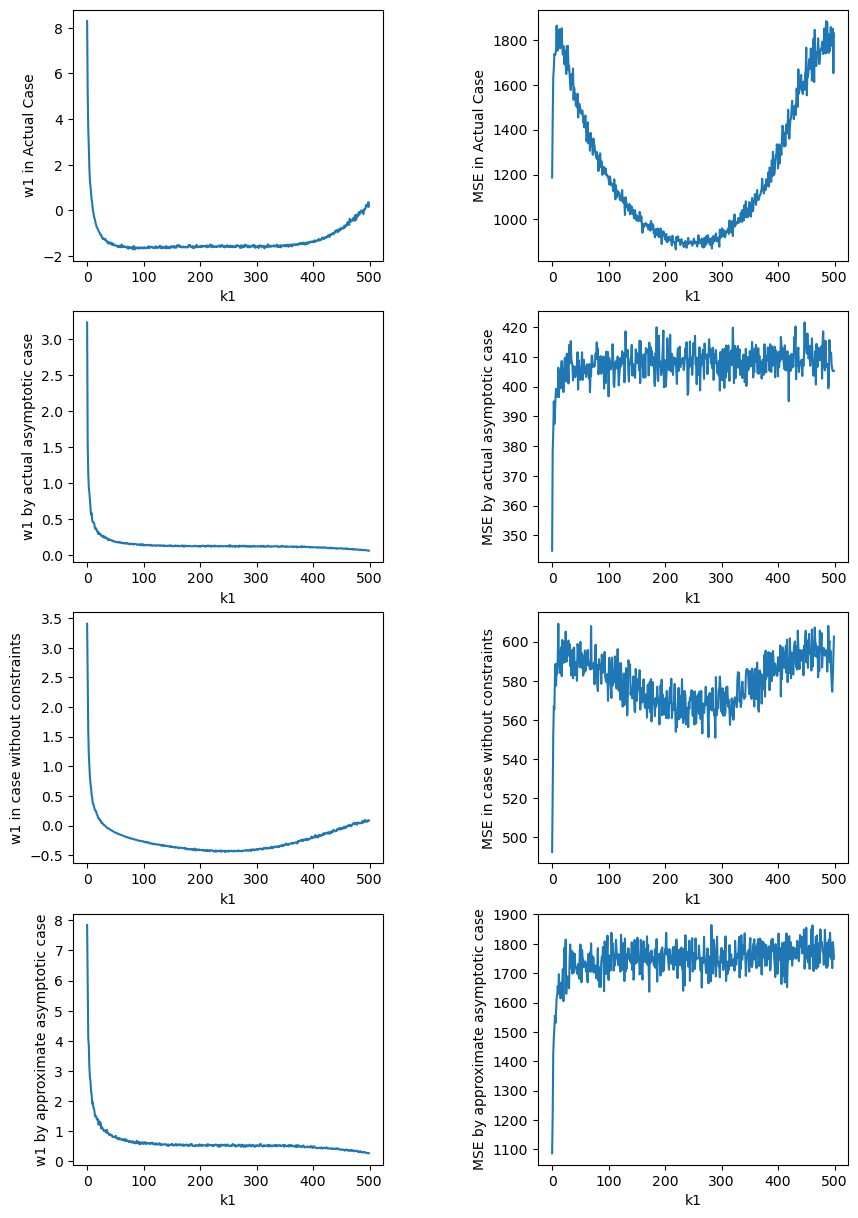

In [308]:
# Monte carlo for normal - Data varies less
print('kVar =', 0.5)
K_3plots(500, 20, 0, 1, 0.5)

In [ ]:
# Monte carlo for normal - Data varies more
print('kVar =', 0.5)
K_3plots(500, 20, 0, 3, 0.5)

In [365]:
def QKspars(de, k):
#     top_k_elements = heapq.nlargest(k, de)
#     if de[0] in top_k_elements:
#         return de[0], 1
#     else:
#         return 0, 0
    kth_largest = np.partition(de, -k)[-k]  # Partially sort and get the kth largest
    print(kth_largest)
#     if de[0] >= kth_largest:
#         return de[0], 1
#     else:
#         return 0, 0    

In [367]:
de = (3, 1, 4, 1, 5, 9, 2, 6)
QKspars(de, 1)

9


In [368]:
klargest = []
for i in range(1, k+1):
    klargest.append(np.partition(de, -i)[-i])
for j in range(de):
    if de[j] in klargest:
        

1
2
3


In [372]:
def top_k_sparsify(array, k):
    # Get the indices of the top-k elements based on absolute value
    topk_indices = sorted(range(len(array)), key=lambda i: abs(array[i]), reverse=True)[:k]

    # Create a new array with only the top-k elements and zeros elsewhere
    sparse_array = [0] * len(array)
    for i in topk_indices:
        sparse_array[i] = array[i]

    return sparse_array

# Example usage
original_array = [-3, 5, -4, 8, 9, 10, 2, -8, 10, 5, -9, 5, 0, 11, 23, -98]
k = 7
sparse_result = top_k_sparsify(original_array, k)
print(sparse_result)  # Output: [0, 5, 0, 8, 9]

<class 'list'>


In [379]:
def mts(m, W, B, K, n, d):
    
    valList = []
    X = np.zeros((d,m))
    Y = np.zeros((d,m))
    for i in range(n):

        for j in range(m):
            X[:, j] = np.random.uniform(-B[j], B[j], d)
            Y[:, j] = np.array(top_k_sparsify(X[:, j], K[j]))
        val = Y@W - X.sum(axis=1)
        valList.append(val.T @ val)
    return np.mean(np.array(valList))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


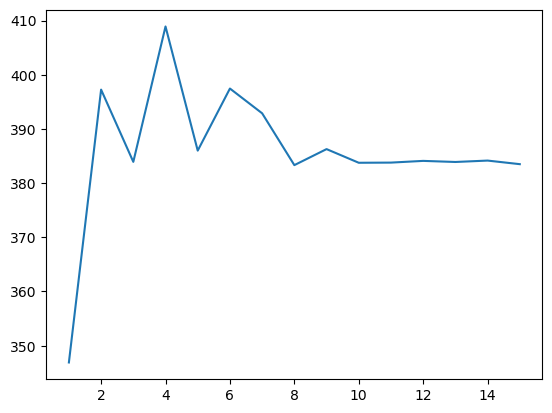

In [387]:
m = 20

B = np.array([random.uniform(-1, -0.1) for _ in range(m)])
K = np.array([20 for _ in range(m)])
W = np.array([0.5 for _ in range(m)])
result = []
x = np.array([i for i in range(1,16)])
for i in range(15):
    result.append(mts(m, W, B, K, 2**i, 200))
    print(i)
plt.plot(x, result);

In [449]:
import numpy as np
from scipy.optimize import minimize


n=10
d = 100
K = np.array([100 for _ in range(m)])
def mts1(W):
    
    valList = []
    X = np.zeros((d,m))
    Y = np.zeros((d,m))
    for i in range(n):

        for j in range(m):
            X[:, j] = np.random.uniform(-B[j], B[j], d)
            Y[:, j] = np.array(top_k_sparsify(X[:, j], K[j]))
        val = Y@W - X.sum(axis=1)
        valList.append(val.T @ val)
    return np.mean(np.array(valList))





def constraint(w):
    return np.sum(w) - m

# # Initial guess for w
# initial_guess = np.ones(20)  # Replace with your desired length

# # Define the constraint
# m = 20  # Desired sum value
# constraint_definition = {'type': 'eq', 'fun': constraint}

# # Perform the optimization
# result = minimize(mts1, initial_guess, constraints=constraint_definition)

# optimized_w = result.x
# print("Optimized w:", optimized_w)
# print("Sum of w:", np.sum(optimized_w))
# print('MSE:', result.fun)


1
6
11


/var/folders/fv/3lzl53fs1j31wyn24dcdgspw0000gn/T/ipykernel_26293/2668238539.py:19: RuntimeWarning: overflow encountered in matmul
  valList.append(val.T @ val)


16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
96


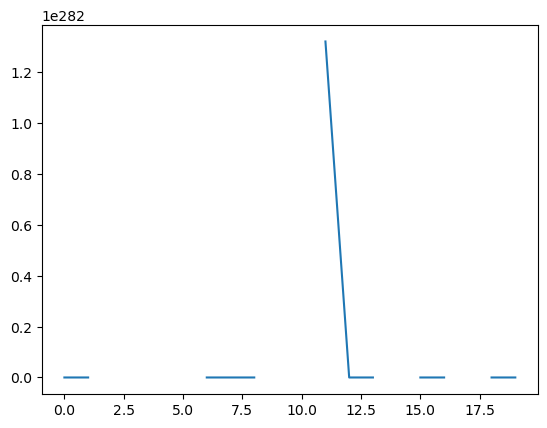

In [450]:
def optimize_sim(n, d):
    
    # Initial guess for w
    initial_guess = np.ones(20)  # Replace with your desired length

    # Define the constraint
    m = 20  # Desired sum value
    constraint_definition = {'type': 'eq', 'fun': constraint}

    # Perform the optimization
    result = minimize(mts1, initial_guess, constraints=constraint_definition)

    optimized_w = result.x
    return optimized_w[0], result.fun  


MSE_list_123 = []
k1_range = list(range(1, 100, 5))
    # Update K here
for k in k1_range:
    print(k)
    K[0] = k
    MSE_list_123.append(optimize_sim(n,d)[1])
plt.plot(MSE_list_123)

In [451]:
print(MSE_list_123)

[5.846973080846419e+233, 2.046245457169939e+177, nan, 4.140529009875751e+171, nan, nan, 5.162659561997189e+245, 7.352532098929897e+274, 4.1849657005788335e+252, nan, nan, 1.3215816036333553e+282, 1.9171108366615716e+188, 1.194007419505617e+193, nan, 7.478055223929218e+264, 3.1542983393334085e+197, nan, 5.685002708068405e+273, 4.747093383118342e+159]


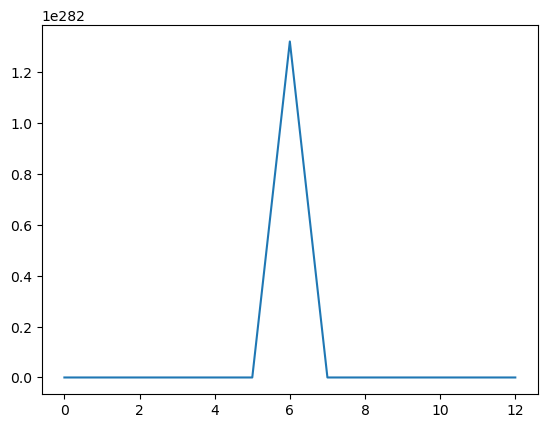

In [453]:
listMSE=[]
for elem in MSE_list_123:
    if elem > 0:
        listMSE.append(elem)
plt.plot(listMSE)

In [431]:
print(listMSE)

[610.3657535432668, 616.3871608876445, 522.8545551501053, 413.87972162802856, 395.5265654260051, 380.16050838046215, 649.8759038076619, 416.9150866484932, 475.61025484706494, 304.5077458146934, 374.74013543294865, 637.5147060105576, 355.60944291223257, 625.8342820301228]


In [436]:
print(list(range(1, 100), 5))

TypeError: list expected at most 1 argument, got 2